In [91]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore #for outlier
from scipy import stats # for plot normal distribution
from xgboost import XGBRegressor
import lightgbm
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import time
from sklearn import svm
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
## Load data

bronx2020 = pd.read_excel(r"NYC_Housing_Dataset_2020/2020_bronx.xlsx",skiprows=6,thousands=',')
brooklyn2020 = pd.read_excel(r"NYC_Housing_Dataset_2020/2020_brooklyn.xlsx",skiprows=6,thousands=',')
manhattan2020 = pd.read_excel(r"NYC_Housing_Dataset_2020/2020_manhattan.xlsx",skiprows=6,thousands=',')
queens2020 = pd.read_excel(r"NYC_Housing_Dataset_2020/2020_queens.xlsx",skiprows=6,thousands=',')
statenisland2020 = pd.read_excel(r"NYC_Housing_Dataset_2020/2020_staten_island.xlsx",skiprows=6,thousands=',')

# Load data for df price prediction 2021
bronx2021 = pd.read_excel("NYC_Housing_Dataset_2021/2021_bronx.xlsx",skiprows=6)
brooklyn2021 = pd.read_excel("NYC_Housing_Dataset_2021/2021_brooklyn.xlsx",skiprows=6)
manhattan2021 = pd.read_excel("NYC_Housing_Dataset_2021/2021_manhattan.xlsx",skiprows=6)
queens2021 = pd.read_excel("NYC_Housing_Dataset_2021/2021_queens.xlsx",skiprows=6)
statensisland2021 = pd.read_excel("NYC_Housing_Dataset_2021/2021_staten_island.xlsx",skiprows=6)

In [3]:
df = pd.concat([manhattan2020, manhattan2021,bronx2020, bronx2021,brooklyn2020,brooklyn2021, 
                 queens2020,queens2021,statenisland2020,statensisland2021], ignore_index=True)
df.columns = [c.replace('\n', '') for c in df.columns]
df.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,SALE DATE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,NaN,B9,231 EAST 7TH,NaN,...,2.0,0.0,2.0,1718.0,5154.0,1901.0,1.0,B9,0.0,2020-10-02
2,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,NaN,C0,243 EAST 7TH STREET,NaN,...,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,0.0,2020-10-31
3,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,NaN,C0,243 EAST 7TH STREET,NaN,...,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,4350000.0,2020-07-16
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,NaN,C7,274 EAST 3RD,NaN,...,9.0,1.0,10.0,2021.0,6445.0,1900.0,2.0,C7,0.0,2020-12-27
5,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,NaN,C7,301-303 EAST 4TH STREET,NaN,...,8.0,2.0,10.0,1501.0,6929.0,1900.0,2.0,C7,3672530.0,2020-11-24
6,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376.0,28.0,NaN,C4,272 EAST 7TH STREET,NaN,...,24.0,0.0,24.0,2764.0,13206.0,1900.0,2.0,C4,1.0,2020-06-26
7,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376.0,31.0,NaN,C4,"278 EAST 7TH STREET, 1A",NaN,...,19.0,0.0,19.0,2772.0,13248.0,1920.0,2.0,C4,2500.0,2020-02-11
8,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376.0,31.0,NaN,C4,"278 EAST 7TH STREET, 1B/2B",NaN,...,19.0,0.0,19.0,2772.0,13248.0,1920.0,2.0,C4,290000.0,2020-02-07
9,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376.0,31.0,NaN,C4,"278 EAST 7TH STREET, 1C/1D",NaN,...,19.0,0.0,19.0,2772.0,13248.0,1920.0,2.0,C4,2500.0,2020-02-11


### Data Cleaning and Data Preprocessing 

In [4]:
## Duplicates

In [5]:
#Delete the duplicates and check that it worked
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [6]:
## Uniqueness

In [7]:
#Check for the number of unique values for every column 
for i in df.columns:
  print(str(i) + ":" + str(df[i].nunique()))

BOROUGH:5
NEIGHBORHOOD:255
BUILDING CLASS CATEGORY:44
TAX CLASS AT PRESENT:10
BLOCK:12764
LOT:3505
EASE-MENT:0
BUILDING CLASS AT PRESENT:167
ADDRESS:159351
APARTMENT NUMBER:6670
ZIP CODE:195
RESIDENTIALUNITS:188
COMMERCIALUNITS:71
TOTAL UNITS:199
LAND SQUARE FEET:8177
GROSS SQUARE FEET:7520
YEAR BUILT:183
TAX CLASS AT TIME OF SALE:3
BUILDING CLASSAT TIME OF SALE:167
SALE PRICE:13678
SALE DATE:731


In [8]:
## Data type transformation 

Since there is no information in EASE-MENT columns, we will drop it initially. We will also drop the SALE DATE column as we are not considering the effect of time on the sale price. 

In [9]:
#Converting columns to respective datatype
categoricalData = ['BOROUGH','TAX CLASS AT PRESENT','BUILDING CLASS CATEGORY',
                    'TAX CLASS AT TIME OF SALE',
                    'BUILDING CLASS AT PRESENT',
                    'BUILDING CLASSAT TIME OF SALE']
for each in categoricalData:
    df[each] = df[each].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = df['SALE PRICE'].replace('[CA\$,]', '', regex=True).astype(float) * 0.77 # convert to US dollars 
df = df.drop(columns=["SALE DATE", "EASE-MENT"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167775 entries, 1 to 167783
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   BOROUGH                        167774 non-null  category
 1   NEIGHBORHOOD                   167774 non-null  object  
 2   BUILDING CLASS CATEGORY        167774 non-null  category
 3   TAX CLASS AT PRESENT           167563 non-null  category
 4   BLOCK                          167774 non-null  float64 
 5   LOT                            167774 non-null  float64 
 6   BUILDING CLASS AT PRESENT      167563 non-null  category
 7   ADDRESS                        167774 non-null  object  
 8   APARTMENT NUMBER               40035 non-null   object  
 9   ZIP CODE                       167762 non-null  float64 
 10  RESIDENTIALUNITS               131344 non-null  float64 
 11  COMMERCIALUNITS                112230 non-null  float64 
 12  TOTAL UNITS     

In [10]:
## Missing values

In [11]:
# Drop LAND SQUARE FEET = 0, GROSS SQUARE FEET = 0, YEAR BUILT = 0   
df = df[df['LAND SQUARE FEET'] > 0]
df = df[df['GROSS SQUARE FEET'] > 0]
df = df[df['YEAR BUILT'] > 0]  
#Drop the missing values
df.dropna(how='all',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90241 entries, 1 to 167780
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   BOROUGH                        90241 non-null  category
 1   NEIGHBORHOOD                   90241 non-null  object  
 2   BUILDING CLASS CATEGORY        90241 non-null  category
 3   TAX CLASS AT PRESENT           90241 non-null  category
 4   BLOCK                          90241 non-null  float64 
 5   LOT                            90241 non-null  float64 
 6   BUILDING CLASS AT PRESENT      90241 non-null  category
 7   ADDRESS                        90241 non-null  object  
 8   APARTMENT NUMBER               792 non-null    object  
 9   ZIP CODE                       90241 non-null  float64 
 10  RESIDENTIALUNITS               90241 non-null  float64 
 11  COMMERCIALUNITS                90241 non-null  float64 
 12  TOTAL UNITS                    

In [12]:
##Check whether dropping nan worked 
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING CLASS CATEGORY              0
TAX CLASS AT PRESENT                 0
BLOCK                                0
LOT                                  0
BUILDING CLASS AT PRESENT            0
ADDRESS                              0
APARTMENT NUMBER                 89449
ZIP CODE                             0
RESIDENTIALUNITS                     0
COMMERCIALUNITS                      0
TOTAL UNITS                          0
LAND SQUARE FEET                     0
GROSS SQUARE FEET                    0
YEAR BUILT                           0
TAX CLASS AT TIME OF SALE            0
BUILDING CLASSAT TIME OF SALE        0
SALE PRICE                           0
dtype: int64

In [13]:
## Outliers

In this case, we will use Z score to detect the outliers in the columns of LAND SQUARE FEET, GROSS SQUARE FEET and SALE PRICE. 
Z score is a significant measure that tells how much a number is above or below the mean of the dataset in terms of standard deviation. We set the threshold=3

In [14]:
df['landSquare_zscore']=zscore(df['LAND SQUARE FEET'])
df.loc[df['landSquare_zscore'].abs()<=3]
print("The count of outliers in LAND SQUARE FEET is: {}".format(len((np.where(zscore(df['LAND SQUARE FEET']) > 3)[0]))))

df['grossSquare_zscore']=zscore(df['GROSS SQUARE FEET'])
df.loc[df['grossSquare_zscore'].abs()<=3]
print("The count of outliers in GROSS SQUARE FEET is: {}".format(len((np.where(zscore(df['GROSS SQUARE FEET']) > 3)[0]))))

df['salePrice_zscore']=zscore(df['SALE PRICE'])
df.loc[df['salePrice_zscore'].abs()<=3]
print("The count of outliers in SALE PRICE is: {}".format(len((np.where(zscore(df['SALE PRICE']) > 3)[0]))))

The count of outliers in LAND SQUARE FEET is: 79
The count of outliers in GROSS SQUARE FEET is: 478
The count of outliers in SALE PRICE is: 367


### Exploratory Data Analysis

### Feature Engineering

In [15]:
df['AGE'] = 2021 - df['YEAR BUILT']

# is the building pre or post war?
df['AGE_CATEGORY'] = np.where(df['AGE']>=76,"Pre-War",'Post-War')

df['AGE_CATEGORY'] = df['AGE_CATEGORY'].astype('category')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore,AGE,AGE_CATEGORY
1,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,B9,231 EAST 7TH,NaN,10009.0,...,5154.0,1901.0,1.0,B9,0.0,-0.040080,-0.021453,-0.123445,120.0,Pre-War
2,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,...,3084.0,1899.0,1.0,C0,0.0,-0.035591,-0.056945,-0.123445,122.0,Pre-War
3,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,...,3084.0,1899.0,1.0,C0,3349500.0,-0.035591,-0.056945,0.371537,122.0,Pre-War
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,C7,274 EAST 3RD,NaN,10009.0,...,6445.0,1900.0,2.0,C7,0.0,-0.038028,0.000682,-0.123445,121.0,Pre-War
5,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,C7,301-303 EAST 4TH STREET,NaN,10009.0,...,6929.0,1900.0,2.0,C7,2827848.1,-0.041549,0.008981,0.294449,121.0,Pre-War


## Converting Borough column to name of each property where it is located.

In [16]:
df['BOROUGH'].unique()

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


[1.0, 2.0, 3.0, 4.0, 5.0]
Categories (5, float64): [1.0, 2.0, 3.0, 4.0, 5.0]

In [17]:
df['BOROUGH'] = df['BOROUGH'].map({1.0:"Manhattan",
                                 2.0:"Bronx",
                                 3.0:"Brooklyn",
                                 4.0:"Queens",
                                 5.0:"Staten Island"})
df['BOROUGH'].unique()

['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
Categories (5, object): ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']

### Target Variable[Sale Price]

##### Visualization of Raw Data

Calculating mean, median and mode for each column in dataframe

In [18]:
df.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore,AGE
count,90241.000000,90241.000000,90241.000000,90241.000000,90241.000000,90241.000000,9.024100e+04,9.024100e+04,90241.000000,9.024100e+04,9.024100e+04,9.024100e+04,9.024100e+04,90241.000000
mean,5514.373256,65.776565,11015.655666,3.870524,0.378730,4.249255,7.638183e+03,6.405224e+03,1942.066987,8.353422e+05,-2.250843e-15,1.846013e-16,-1.406422e-14,78.933013
std,3700.303012,144.509092,464.416430,38.313846,9.843209,39.671182,1.477109e+05,5.832344e+04,31.084951,6.766940e+06,1.000006e+00,1.000006e+00,1.000006e+00,31.084951
min,1.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,3.500000e+01,1.000000e+00,1018.000000,0.000000e+00,-5.147369e-02,-1.098059e-01,-1.234453e-01,0.000000
25%,2651.000000,19.000000,10465.000000,1.000000,0.000000,1.000000,2.000000e+03,1.420000e+03,1920.000000,0.000000e+00,-3.817060e-02,-8.547595e-02,-1.234453e-01,61.000000
50%,5056.000000,39.000000,11221.000000,2.000000,0.000000,2.000000,2.500000e+03,1.988000e+03,1931.000000,3.657500e+05,-3.478559e-02,-7.573710e-02,-6.939544e-02,90.000000
75%,7714.000000,64.000000,11372.000000,2.000000,0.000000,2.000000,4.000000e+03,2.812000e+03,1960.000000,6.545000e+05,-2.463056e-02,-6.160891e-02,-2.672451e-02,101.000000
max,16330.000000,8165.000000,11695.000000,8764.000000,2261.000000,8812.000000,7.649136e+06,8.942176e+06,2021.000000,7.531296e+08,5.173308e+01,1.532115e+02,1.111726e+02,1003.000000


In [19]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASSAT TIME OF SALE', 'SALE PRICE', 'landSquare_zscore',
       'grossSquare_zscore', 'salePrice_zscore', 'AGE', 'AGE_CATEGORY'],
      dtype='object')

In [20]:
N = 'Nominal'
O = 'Ordinal'
I = 'Interval'
R = "Ratio"

In [21]:
NOIR_Classification={"BOROUGH":N,
                    "NEIGHBORHOOD":N,
                    "BUILDING CLASS CATEGORY":O,
                    "TAX CLASS AT PRESENT":O,
                    "BLOCK":N,
                    "LOT":N,
                    "BUILDING CLASS AT PRESENT":N,
                    "ADDRESS":N,
                    "APARTMENT NUMBER":N,
                    "ZIP CODE":N,
                    "RESIDENTIALUNITS":N,
                    "COMMERCIALUNITS":N,
                    "TOTAL UNITS":N,
                    "LAND SQUARE FEET":N,
                    "GROSS SQUARE FEET":N,
                    "YEAR BUILT":O,
                    "TAX CLASS AT TIME OF SALE":O,
                    "BUILDING CLASSAT TIME OF SALE":N,
                    "SALE PRICE":N,
                    "SALE DATE":O,
                     'AGE': R,
                     'AGE_CATEGORY': O

                   }

In [22]:
for key,value in NOIR_Classification.items():
    print(f"Column: {key}\t\t\t Classification Type :{value}")

Column: BOROUGH			 Classification Type :Nominal
Column: NEIGHBORHOOD			 Classification Type :Nominal
Column: BUILDING CLASS CATEGORY			 Classification Type :Ordinal
Column: TAX CLASS AT PRESENT			 Classification Type :Ordinal
Column: BLOCK			 Classification Type :Nominal
Column: LOT			 Classification Type :Nominal
Column: BUILDING CLASS AT PRESENT			 Classification Type :Nominal
Column: ADDRESS			 Classification Type :Nominal
Column: APARTMENT NUMBER			 Classification Type :Nominal
Column: ZIP CODE			 Classification Type :Nominal
Column: RESIDENTIALUNITS			 Classification Type :Nominal
Column: COMMERCIALUNITS			 Classification Type :Nominal
Column: TOTAL UNITS			 Classification Type :Nominal
Column: LAND SQUARE FEET			 Classification Type :Nominal
Column: GROSS SQUARE FEET			 Classification Type :Nominal
Column: YEAR BUILT			 Classification Type :Ordinal
Column: TAX CLASS AT TIME OF SALE			 Classification Type :Ordinal
Column: BUILDING CLASSAT TIME OF SALE			 Classification Type :Nomin

In [23]:
df['SALE PRICE'].describe()

count    9.024100e+04
mean     8.353422e+05
std      6.766940e+06
min      0.000000e+00
25%      0.000000e+00
50%      3.657500e+05
75%      6.545000e+05
max      7.531296e+08
Name: SALE PRICE, dtype: float64

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 56.910382


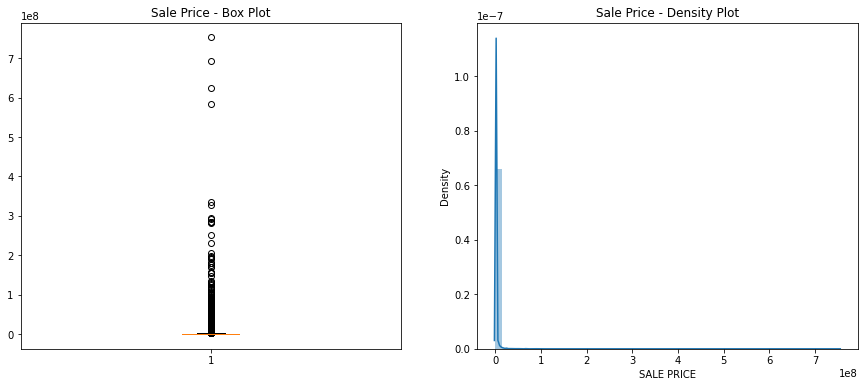

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.boxplot(df['SALE PRICE'])
plt.title('Sale Price - Box Plot')
plt.subplot(1,2,2)
sns.distplot(df['SALE PRICE'])
plt.title('Sale Price - Density Plot')
# Skewness
print("Skewness: %f" % df['SALE PRICE'].skew())
plt.show()

##### Range set-up & Log-Transformation

In [25]:
# Sale price percentage = $0
len(df.loc[df['SALE PRICE'] == 0 ])/len(df)

0.4039848849192717

In [26]:
# Sale price percentage < $50000
len(df.loc[df['SALE PRICE'] < 50000])/len(df)

0.4304695205062001

In [27]:
# Sale price percentage > 12000000
len(df.loc[df['SALE PRICE'] > 12000000 ])/len(df)

0.007635110426524529

##### Observation: 

It is observed that a lot of sales occur with an absurdly small number: \\$0  most commonly ( 40%  of the sale price =  \\$0 ). 
On the basis of the original data resource, it is noted that these sales are in effect transfers of deeds between parties. For instance, the transfer of ownership of the house from parents to the child after the parents move out for retirement. To handle this situation, a reasonable range for the sale price will be set up. The instances for which the sale price is greater than \\$12M and less than \\$50000 will be removed since it will help eliminate the special cases. Following which, log transformation can be performed. 

In [28]:
#Removing rows where year_built is equal to zero because these rows can be considered as outliers
df = df[df['YEAR BUILT']!=0]

In [29]:
df[df['YEAR BUILT']>1600]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore,AGE,AGE_CATEGORY
1,Manhattan,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,B9,231 EAST 7TH,NaN,10009.0,...,5154.0,1901.0,1.0,B9,0.00,-0.040080,-0.021453,-0.123445,120.0,Pre-War
2,Manhattan,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,...,3084.0,1899.0,1.0,C0,0.00,-0.035591,-0.056945,-0.123445,122.0,Pre-War
3,Manhattan,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,...,3084.0,1899.0,1.0,C0,3349500.00,-0.035591,-0.056945,0.371537,122.0,Pre-War
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,C7,274 EAST 3RD,NaN,10009.0,...,6445.0,1900.0,2.0,C7,0.00,-0.038028,0.000682,-0.123445,121.0,Pre-War
5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,C7,301-303 EAST 4TH STREET,NaN,10009.0,...,6929.0,1900.0,2.0,C7,2827848.10,-0.041549,0.008981,0.294449,121.0,Pre-War
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167776,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7349.0,82.0,B9,66 PHEASANT LANE,NaN,10309.0,...,2178.0,1999.0,1.0,B9,169379.21,-0.035205,-0.072479,-0.098415,22.0,Post-War
167777,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7351.0,22.0,B2,22 HERRICK AVENUE,NaN,10309.0,...,2400.0,2000.0,1.0,B2,0.00,-0.024631,-0.068673,-0.123445,21.0,Post-War
167778,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7355.0,79.0,B9,86 AMBASSADOR LANE,NaN,10309.0,...,2250.0,2001.0,1.0,B9,423500.00,-0.033804,-0.071245,-0.060861,20.0,Post-War
167779,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7355.0,86.0,B9,106 AMBASSADOR LANE,NaN,10309.0,...,2565.0,2001.0,1.0,B9,491645.00,-0.034366,-0.065844,-0.050791,20.0,Post-War


/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


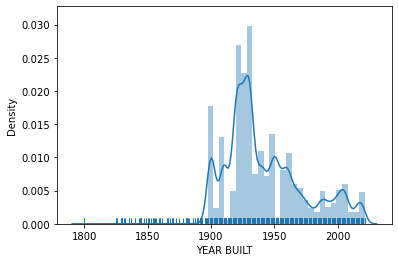

In [30]:
# Create a chart showing how distributed is Year Built
sns.distplot(df[df['YEAR BUILT']>1600]['YEAR BUILT'],bins=50,rug=True,kde=True)
plt.show()

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

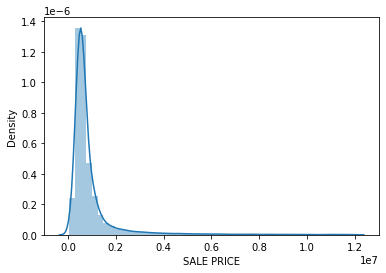

In [31]:
df = df[(df['SALE PRICE'] > 50000) & (df['SALE PRICE'] < 12000000)]
sns.distplot(df['SALE PRICE'])

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sale Price - Box Plot')

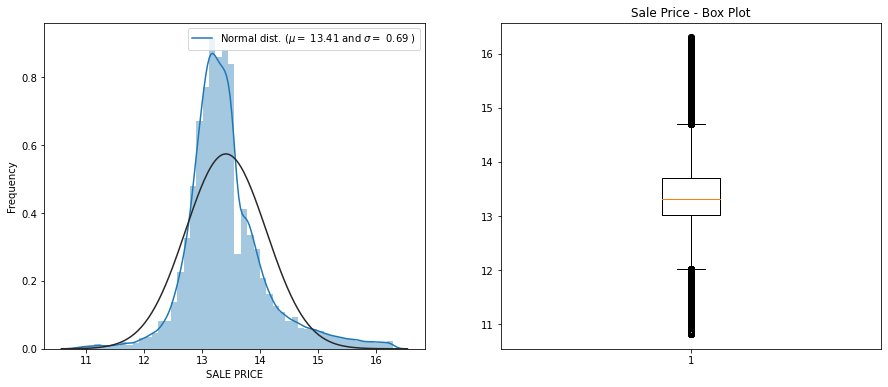

In [32]:
# log(x) transform

df["SALE PRICE"]=np.log(df["SALE PRICE"])

plt.subplots(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(df["SALE PRICE"], fit = stats.norm)
plt.ylabel('Frequency')
(mu, sigma) = stats.norm.fit(df["SALE PRICE"])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.subplot(1,2,2)
plt.boxplot(df['SALE PRICE'])
plt.title('Sale Price - Box Plot')

#### Feature Analysis and Selection 

In [33]:
df = df.drop(['salePrice_zscore', 'landSquare_zscore', 'grossSquare_zscore'],axis =1)
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASSAT TIME OF SALE', 'SALE PRICE', 'AGE', 'AGE_CATEGORY'],
      dtype='object')

#### (i) Correlation 

<AxesSubplot:>

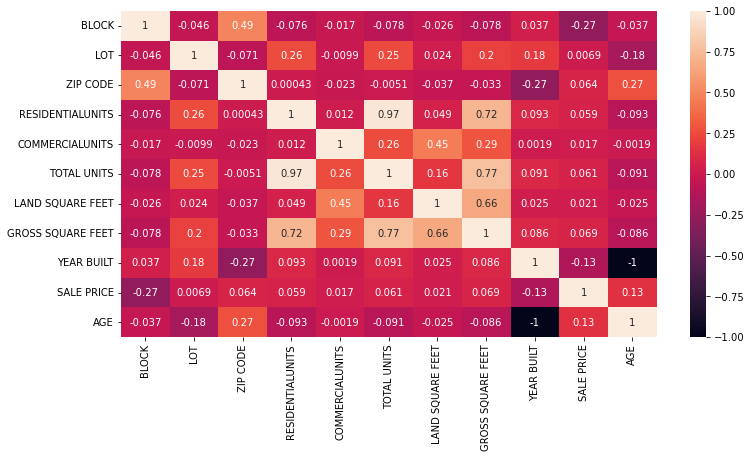

In [34]:
#Colinearity heatmap
corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)

#### (ii) Feature Analysis and Selection

a. BOROUGH

Explanation: The name of the borough in which the property is located.

1 = Bronx\
2 = Brooklyn\
3 = Manhattan\
4 = Queens\
5 = Staten Island

<AxesSubplot:title={'center':'Mean Sale Price in each BOROUGH'}, xlabel='BOROUGH'>

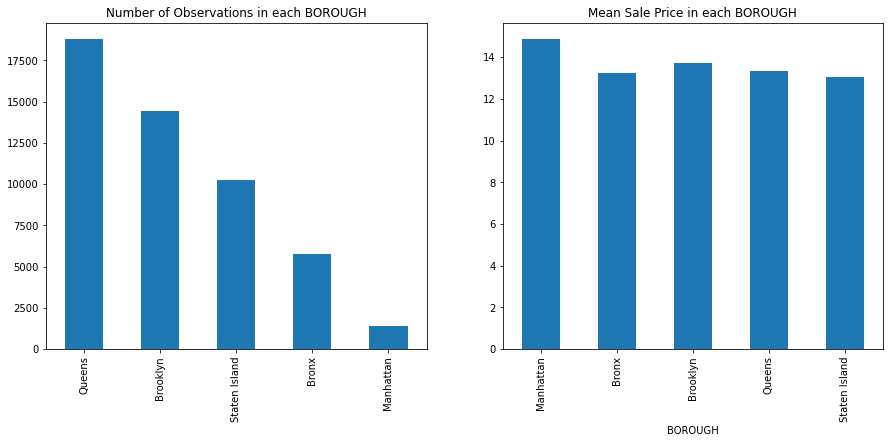

In [35]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Number of Observations in each BOROUGH")
df['BOROUGH'].value_counts().plot(kind='bar')

# Average price by borough
plt.subplot(1,2,2)
plt.title("Mean Sale Price in each BOROUGH")
df.groupby('BOROUGH').mean()['SALE PRICE'].plot(kind = 'bar')

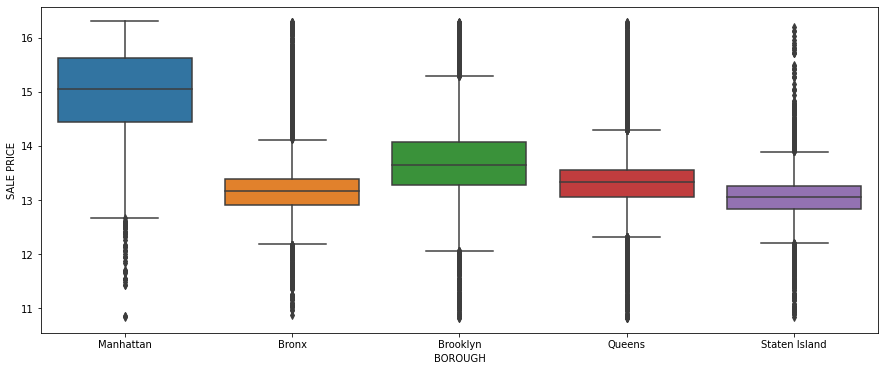

In [36]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['BOROUGH'].astype('category'), y = df['SALE PRICE'], data=pd.melt(df))
plt.show()

In [77]:
# Calculating Average Sales Price for Each Borough
df_bar = df[['BOROUGH','SALE PRICE']].groupby(by='BOROUGH').mean().sort_values(by='SALE PRICE',ascending=False).reset_index()
df_bar

,BOROUGH,SALE PRICE
0,Manhattan,14.893404
1,Brooklyn,13.706020
2,Queens,13.325958
3,Bronx,13.242126
4,Staten Island,13.048383


### Created a bar plot comparing Average Sales Price among different Boroughs

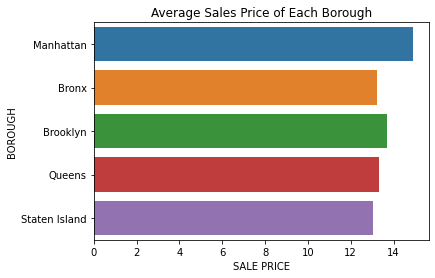

In [78]:
sns.barplot(y='BOROUGH',x = 'SALE PRICE',data = df_bar)
plt.title("Average Sales Price of Each Borough")
plt.show()

In [37]:
df['ZIP CODE'].nunique()

175

##### Finding top 10 zipcodes with highest sales

#### b. NEIGHBORHOOD

Explanation: While evaluating properties, the name of hte neighborhood is determined by the Department of Finance assessors. Although, the common name of the neighborhood is the same as designated by the Finance department, slight differences may occur when it comes to neighborhood boundary lines. It is also noted that a few sub-neighborhoods might not be included. 

Text(0, 0.5, 'Average sale price')

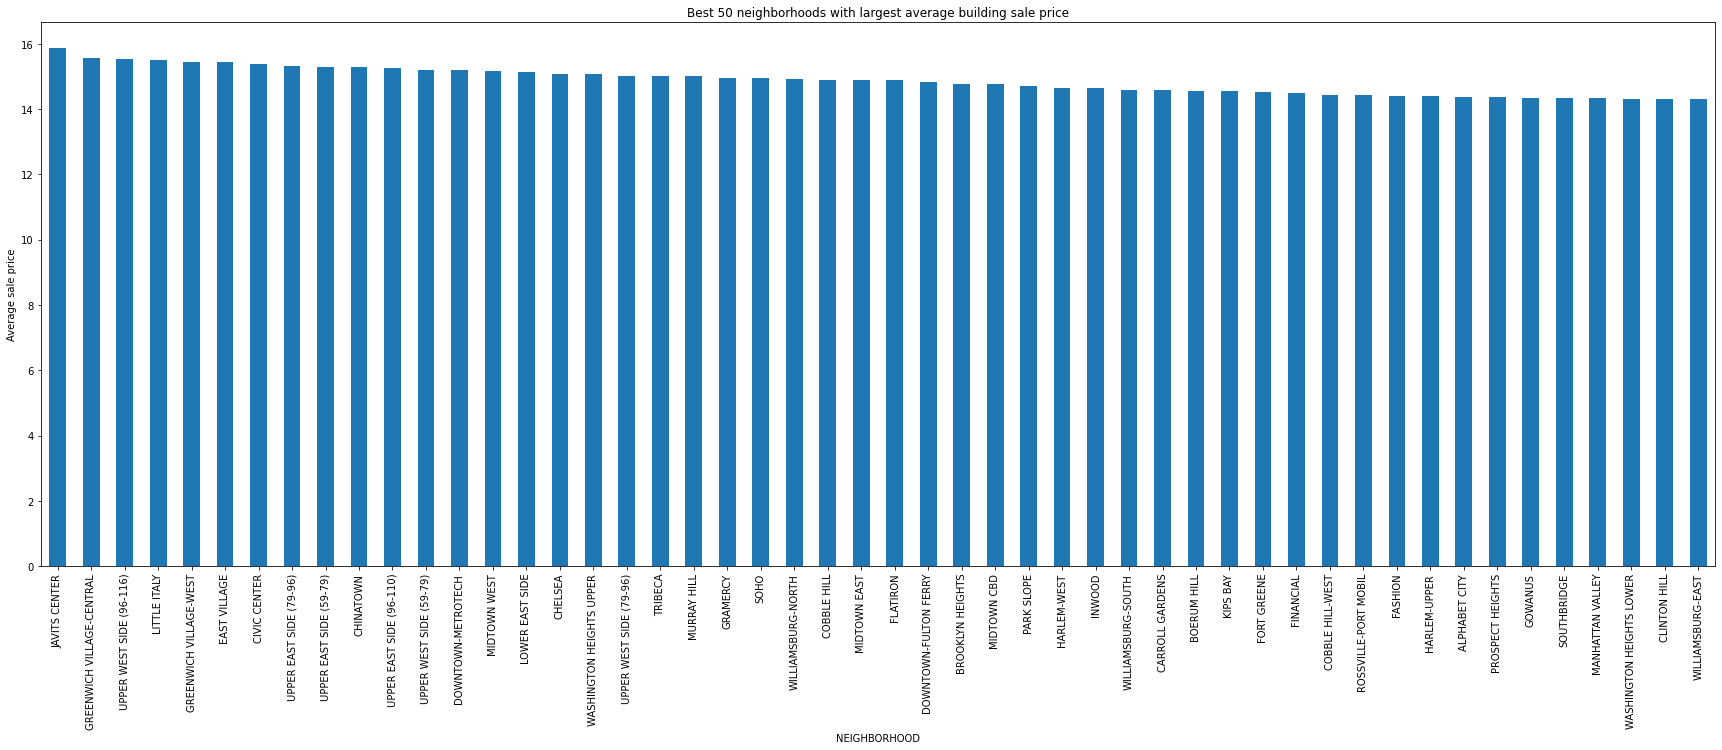

In [38]:
# Best 50 neighborhoods having largest average building sale price
plt.figure(figsize=(30,10))
df.groupby('NEIGHBORHOOD').mean()['SALE PRICE'].sort_values(ascending = False).head(50).plot(kind = 'bar')
plt.title("Best 50 neighborhoods with largest average building sale price")
plt.ylabel('Average sale price')

#### Building Class category

Explanation: To help the users of the Rolling Sales Files to identify similar properties by broad usage such as One Family Homes without having to look up Individual Buildign Classes, this filed is included. The files are sorted by Borough, Neighborhood, Block, Building Class Category and Lot.  

In [39]:
df['BUILDING CLASS CATEGORY'].unique()

['03 THREE FAMILY DWELLINGS', '07 RENTALS - WALKUP APARTMENTS', '14 RENTALS - 4-10 UNIT', '01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS', ..., '35 INDOOR PUBLIC AND CULTURAL FACILITIES', '39 TRANSPORTATION FACILITIES', '27 FACTORIES', '36 OUTDOOR RECREATIONAL FACILITIES', '34 THEATRES']
Length: 23
Categories (44, object): ['01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS', '03 THREE FAMILY DWELLINGS', '04 TAX CLASS 1 CONDOS', ..., '46 CONDO STORE BUILDINGS', '47 CONDO NON-BUSINESS STORAGE', '48 CONDO TERRACES/GARDENS/CABANAS', '49 CONDO WAREHOUSES/FACTORY/INDUS']

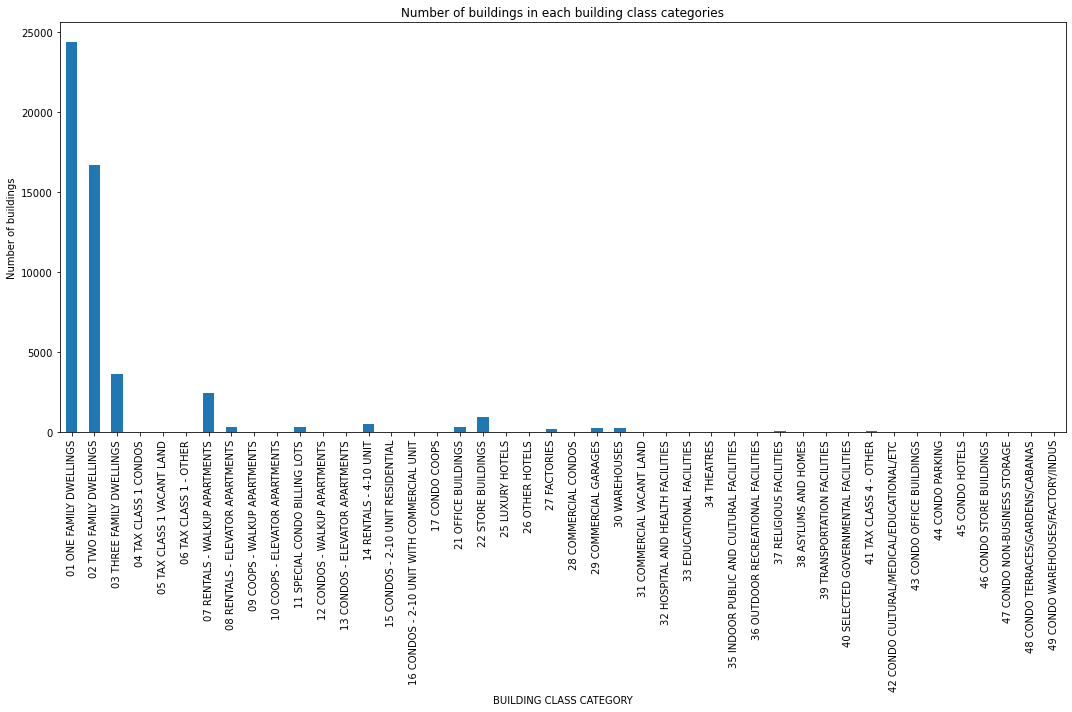

In [40]:
# number of buildings by building class category
plt.figure(figsize=(15,10))
df.groupby('BUILDING CLASS CATEGORY').size().plot(kind = 'bar')
plt.title('Number of buildings in each building class categories')
plt.ylabel('Number of buildings')

plt.tight_layout()
plt.show()

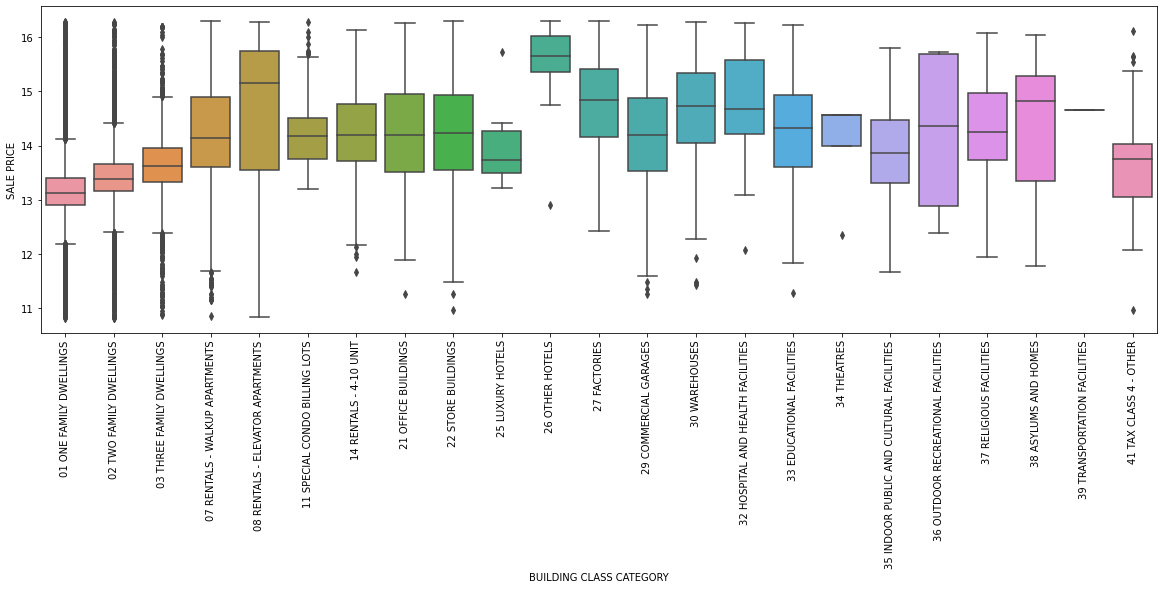

In [41]:
plt.figure(figsize=(20,6))
order = sorted(df['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x=df['BUILDING CLASS CATEGORY'], y = df['SALE PRICE'], data=df, order=order)
plt.xticks(rotation = 90)
plt.show()

In [42]:
df['TAX CLASS AT TIME OF SALE'].value_counts()

1.0    44758
2.0     3583
4.0     2365
Name: TAX CLASS AT TIME OF SALE, dtype: int64

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


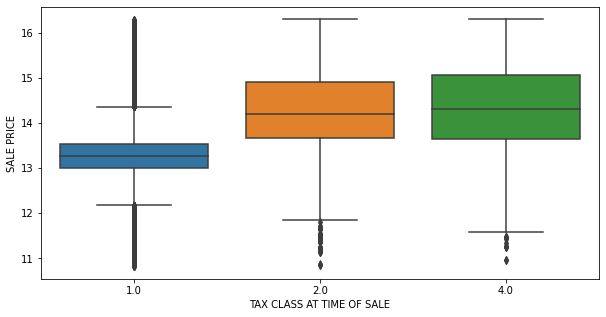

In [43]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['TAX CLASS AT TIME OF SALE'], y = df['SALE PRICE'], data=pd.melt(df))
plt.show()

In [44]:
## Block and Lot

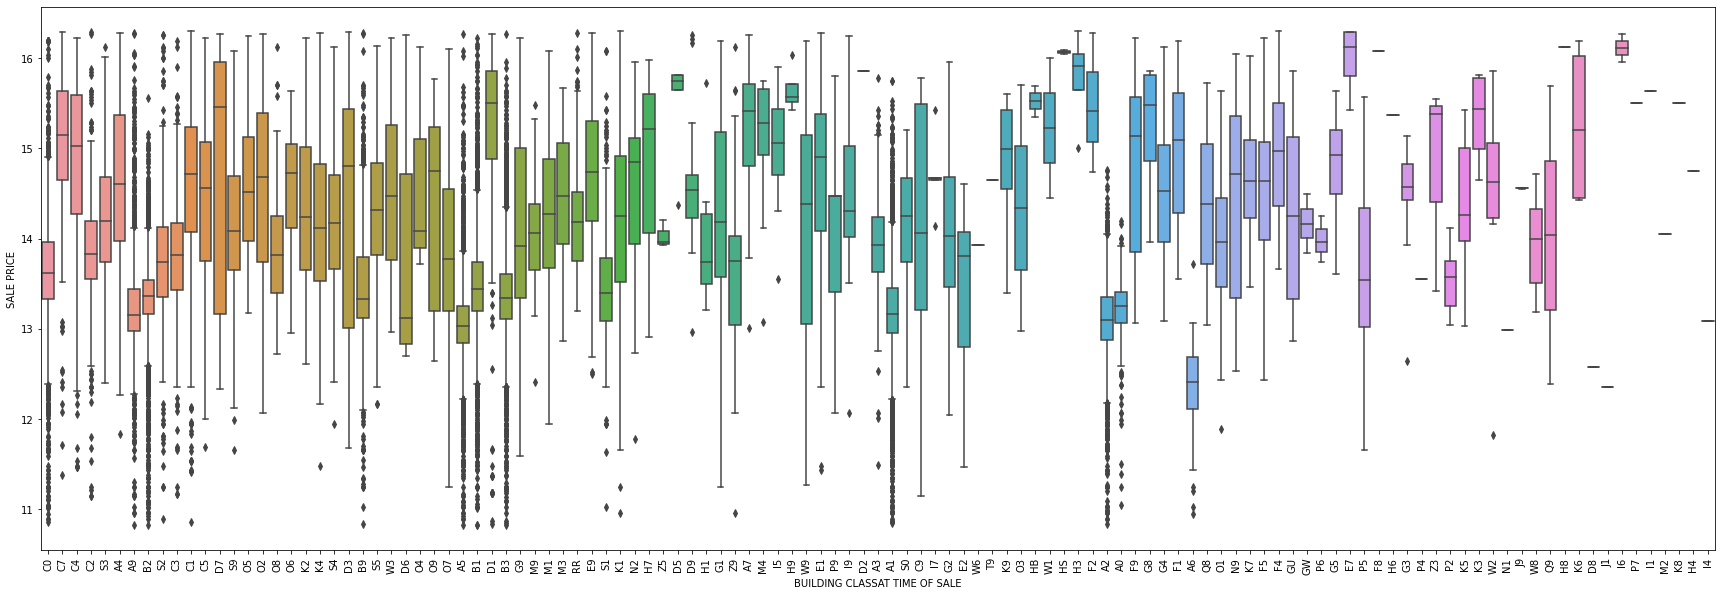

In [45]:
plt.figure(figsize=(30,10))
order = df['BUILDING CLASSAT TIME OF SALE'].unique()
sns.boxplot(x='BUILDING CLASSAT TIME OF SALE', y='SALE PRICE', data=df, order = order)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 0, 'Year Built')

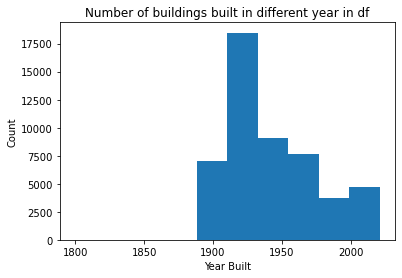

In [46]:
plt.hist(df['YEAR BUILT'])
plt.title('Number of buildings built in different year in df')
plt.ylabel('Count')
plt.xlabel("Year Built")

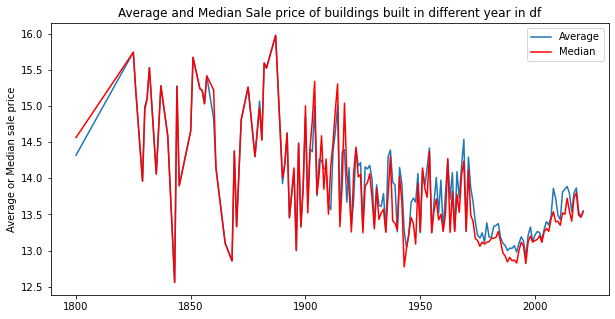

In [47]:
plt.figure(figsize=(10,5))
plt.plot(df.groupby('YEAR BUILT').mean()['SALE PRICE'])
plt.plot(df.groupby('YEAR BUILT').median()['SALE PRICE'],color='r')
plt.title('Average and Median Sale price of buildings built in different year in df')
plt.ylabel('Average or Median sale price')
plt.legend(['Average','Median'])

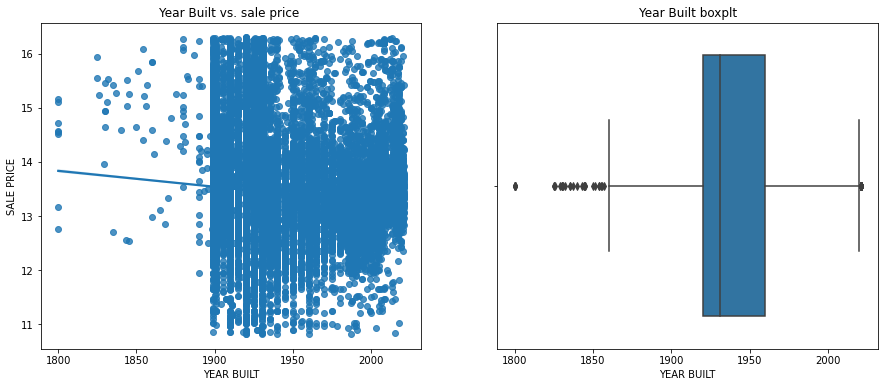

In [48]:
# Year Built
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

sns.regplot(x='YEAR BUILT', y='SALE PRICE',data=df)
plt.title('Year Built vs. sale price ')
plt.subplot(1,2,2)
sns.boxplot(x= 'YEAR BUILT', data=df)
plt.title('Year Built boxplt')
plt.show()

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 250.0)

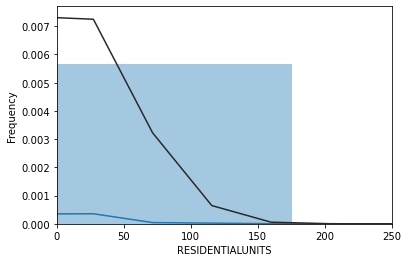

In [49]:
#density plot
sns.distplot(df['RESIDENTIALUNITS'],fit = stats.norm)
plt.ylabel('Frequency')
plt.xlim([0,250])

<Figure size 1080x432 with 0 Axes>

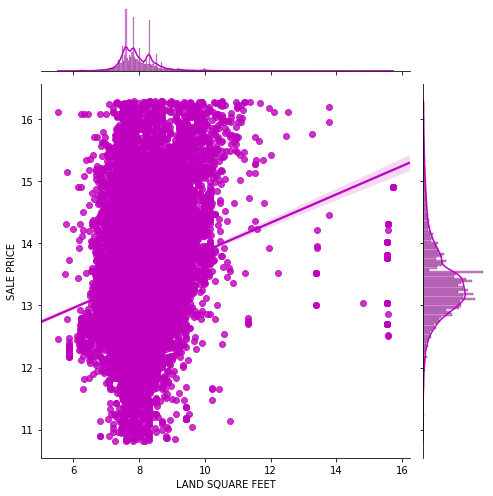

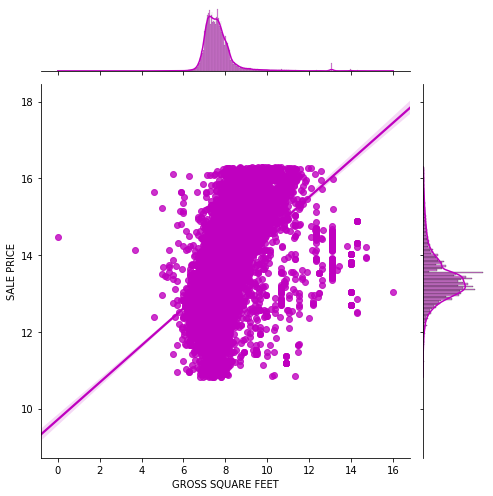

In [50]:
df['LAND SQUARE FEET']=np.log(df['LAND SQUARE FEET'])
df['GROSS SQUARE FEET']=np.log(df['GROSS SQUARE FEET'])
plt.figure(figsize=(15,6));
a=sns.jointplot(x="LAND SQUARE FEET", y="SALE PRICE", data=df,
                  kind="reg", truncate=False,
                  color="m", height=7);
b=sns.jointplot(x="GROSS SQUARE FEET", y="SALE PRICE", data=df,
                  kind="reg", truncate=False,
                  color="m", height=7);

### 3.3 Summary

Based on previous data visulization and analysis, we will drop these features: 

NEIGHBORHOOD, ADDRESS, APARTMENT NUMBER, BLOCK, LOT, ZIP CODE, BLOCK, TAX CLASS AS OF FINAL ROLL 18/19, 
BUILDING AS OF FINAL ROLL 18/19 

In [51]:
df = df.drop(columns=["ADDRESS", "APARTMENT NUMBER", "LOT", "ZIP CODE", "BLOCK", 
                        "NEIGHBORHOOD", "TAX CLASS AT TIME OF SALE",
                        "BUILDING CLASSAT TIME OF SALE"])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50706 entries, 3 to 167780
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BOROUGH                    50706 non-null  category
 1   BUILDING CLASS CATEGORY    50706 non-null  category
 2   TAX CLASS AT PRESENT       50706 non-null  category
 3   BUILDING CLASS AT PRESENT  50706 non-null  category
 4   RESIDENTIALUNITS           50706 non-null  float64 
 5   COMMERCIALUNITS            50706 non-null  float64 
 6   TOTAL UNITS                50706 non-null  float64 
 7   LAND SQUARE FEET           50706 non-null  float64 
 8   GROSS SQUARE FEET          50706 non-null  float64 
 9   YEAR BUILT                 50706 non-null  float64 
 10  SALE PRICE                 50706 non-null  float64 
 11  AGE                        50706 non-null  float64 
 12  AGE_CATEGORY               50706 non-null  category
dtypes: category(5), float64(8)
mem

In [53]:
categoricals= ['BOROUGH', 'BUILDING CLASS AT PRESENT','TAX CLASS AT PRESENT',
               'BUILDING CLASS CATEGORY']
one_hot_encoded = pd.get_dummies(df[categoricals])
df_new = df.drop(categoricals,axis = 1)
df_new = df_new.join(one_hot_encoded).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50706 entries, 3 to 167780
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BOROUGH                    50706 non-null  category
 1   BUILDING CLASS CATEGORY    50706 non-null  category
 2   TAX CLASS AT PRESENT       50706 non-null  category
 3   BUILDING CLASS AT PRESENT  50706 non-null  category
 4   RESIDENTIALUNITS           50706 non-null  float64 
 5   COMMERCIALUNITS            50706 non-null  float64 
 6   TOTAL UNITS                50706 non-null  float64 
 7   LAND SQUARE FEET           50706 non-null  float64 
 8   GROSS SQUARE FEET          50706 non-null  float64 
 9   YEAR BUILT                 50706 non-null  float64 
 10  SALE PRICE                 50706 non-null  float64 
 11  AGE                        50706 non-null  float64 
 12  AGE_CATEGORY               50706 non-null  category
dtypes: category(5), float64(8)
mem

In [54]:
df_new

,index,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,AGE,AGE_CATEGORY,...,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS
0,3,3.0,0.0,3.0,7.775276,8.033983,1899.0,15.024322,122.0,Pre-War,...,0,0,0,0,0,0,0,0,0,0
1,5,8.0,2.0,10.0,7.313887,8.843471,1900.0,14.855027,121.0,Pre-War,...,0,0,0,0,0,0,0,0,0,0
2,8,19.0,0.0,19.0,7.927324,9.491602,1920.0,12.316271,101.0,Pre-War,...,0,0,0,0,0,0,0,0,0,0
3,20,19.0,0.0,19.0,7.927324,9.491602,1920.0,11.477700,101.0,Pre-War,...,0,0,0,0,0,0,0,0,0,0
4,24,28.0,0.0,28.0,8.421123,9.812140,1900.0,13.018002,121.0,Pre-War,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50701,167775,2.0,0.0,2.0,7.839919,7.604396,1998.0,13.161103,23.0,Post-War,...,0,0,0,0,0,0,0,0,0,0
50702,167776,2.0,0.0,2.0,7.798933,7.686162,1999.0,12.039895,22.0,Post-War,...,0,0,0,0,0,0,0,0,0,0
50703,167778,2.0,0.0,2.0,7.880426,7.718685,2001.0,12.956309,20.0,Post-War,...,0,0,0,0,0,0,0,0,0,0
50704,167779,2.0,0.0,2.0,7.848543,7.849714,2001.0,13.105512,20.0,Post-War,...,0,0,0,0,0,0,0,0,0,0


/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log(LAND SQUARE FEET) density plot')

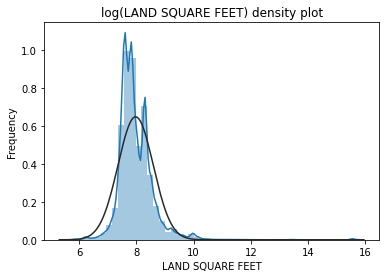

In [55]:
#density plot
sns.distplot(df_new['LAND SQUARE FEET'],fit = stats.norm)
plt.ylabel('Frequency')
plt.title("log(LAND SQUARE FEET) density plot")

/Users/priyankjagad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log(GROSS SQUARE FEET) density plot')

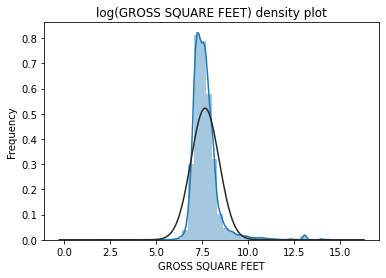

In [56]:
#density plot
sns.distplot(df_new['GROSS SQUARE FEET'],fit = stats.norm)
plt.ylabel('Frequency')
plt.title("log(GROSS SQUARE FEET) density plot")

In [57]:
df.columns

Index(['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'RESIDENTIALUNITS', 'COMMERCIALUNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE', 'AGE', 'AGE_CATEGORY'],
      dtype='object')

In [58]:
df_new.columns

Index(['index', 'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE',
       'AGE', 'AGE_CATEGORY',
       ...
       'BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES',
       'BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER',
       'BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC',
       'BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS',
       'BUILDING CLASS CATEGORY_44 CONDO PARKING',
       'BUILDING CLASS CATEGORY_45 CONDO HOTELS',
       'BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS',
       'BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE',
       'BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS',
       'BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS'],
      dtype='object', length=236)

In [59]:
df_new.drop('AGE_CATEGORY',axis='columns',inplace=True)

In [60]:
from sklearn.model_selection import train_test_split

X = df_new.drop(['SALE PRICE'], axis = 1)
y = df_new['SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("The R2 score of linear regression model is ", r2_score(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The R2 score of linear regression model is  0.48143978904259954
MSE: 0.2547788956656847
RMSE: 0.5047562735278133


# RANSAC Regression

The R2 score of RANSAC Regression model is  -2.2491503932516244
MSE: 1.5963718996411365
RMSE: 1.2634761175586726


Text(0.5, 1.0, 'Residual plot of RANSAC Regression')

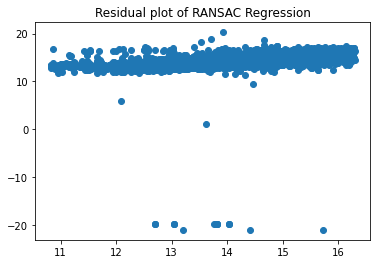

In [62]:
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt

model = RANSACRegressor(max_trials=1000)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("The R2 score of RANSAC Regression model is ", r2_score(y_test, test_pred))
print('MSE:', metrics.mean_squared_error(y_test, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))
      
plt.scatter(y_test, test_pred)

plt.title('Residual plot of RANSAC Regression')

# Lasso Regression

The R2 score of Lasso Regression model is  0.2909290221322167
MSE: 0.3483806062871681
RMSE: 0.5902377540340571


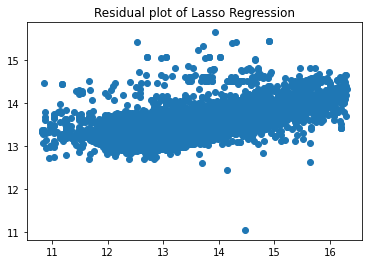

In [63]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train, y_train)
lasso_reg_predict = lasso_reg.predict(X_test)

print("The R2 score of Lasso Regression model is ", r2_score(y_test, lasso_reg_predict))
print('MSE:', metrics.mean_squared_error(y_test, lasso_reg_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_reg_predict)))

plt.title('Residual plot of Lasso Regression')

plt.scatter(y_test, lasso_reg_predict)

# Ridge Regression

The R2 score of Ridge Regression model is  0.48181831621448656
MSE: 0.2545929177738315
RMSE: 0.5045720144576307


Text(0.5, 1.0, 'Residual plot of Ridge Regression')

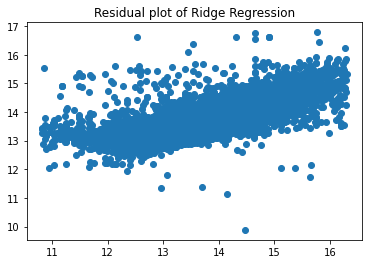

In [64]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1)
ridge_reg.fit(X_train, y_train)
ridge_reg_predict = ridge_reg.predict(X_test)

print("The R2 score of Ridge Regression model is ", r2_score(y_test, ridge_reg_predict))
print('MSE:', metrics.mean_squared_error(y_test, ridge_reg_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_reg_predict)))

plt.scatter(y_test, ridge_reg_predict)
plt.title('Residual plot of Ridge Regression')

# ElasticNet Model

The R2 score of ElasticNet model is  0.2978064965228131
MSE: 0.3450015669910947
RMSE: 0.5873683401334249


Text(0.5, 1.0, 'Residual plot of Elastic Net')

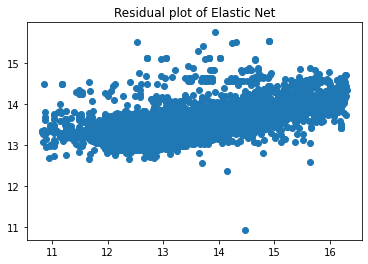

In [65]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)
elastic_predict = model.predict(X_test)

print("The R2 score of ElasticNet model is ", r2_score(y_test, elastic_predict))
print('MSE:', metrics.mean_squared_error(y_test, elastic_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, elastic_predict)))

plt.scatter(y_test, elastic_predict)
plt.title('Residual plot of Elastic Net')

# XGBoost Regression

In [86]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred2 = xgb.predict(X_test)
print("The R2 score of xgb regression model is", r2_score(y_test,y_pred2))
print('MSE:', metrics.mean_squared_error(y_test, y_pred2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

The R2 score of xgb regression model is 0.6544531047661667
MSE: 0.16977402914473588
RMSE: 0.41203644152518343


# Light GBM Regression - Gradient Boosting Machine

The R2 score of Light GBM Regression model is  0.629007234553102
MSE: 0.1822760888383778
RMSE: 0.4269380386407116


Text(0.5, 1.0, 'Residual plot of LGBM')

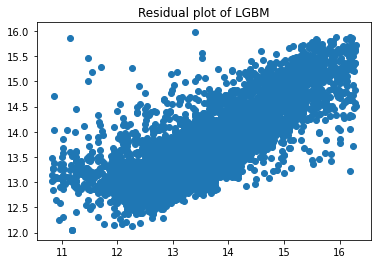

In [66]:
import lightgbm
import time
lgbm = lightgbm.LGBMRegressor(random_state = 42)
start = time.process_time()
model = lgbm.fit(X_train,y_train)
lgbm_predict =  model.predict(X_test)

print("The R2 score of Light GBM Regression model is ", r2_score(y_test, lgbm_predict))
print('MSE:', metrics.mean_squared_error(y_test, lgbm_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgbm_predict)))

plt.scatter(y_test, lgbm_predict)
plt.title('Residual plot of LGBM')

# Feature Importance of the Ridge Model

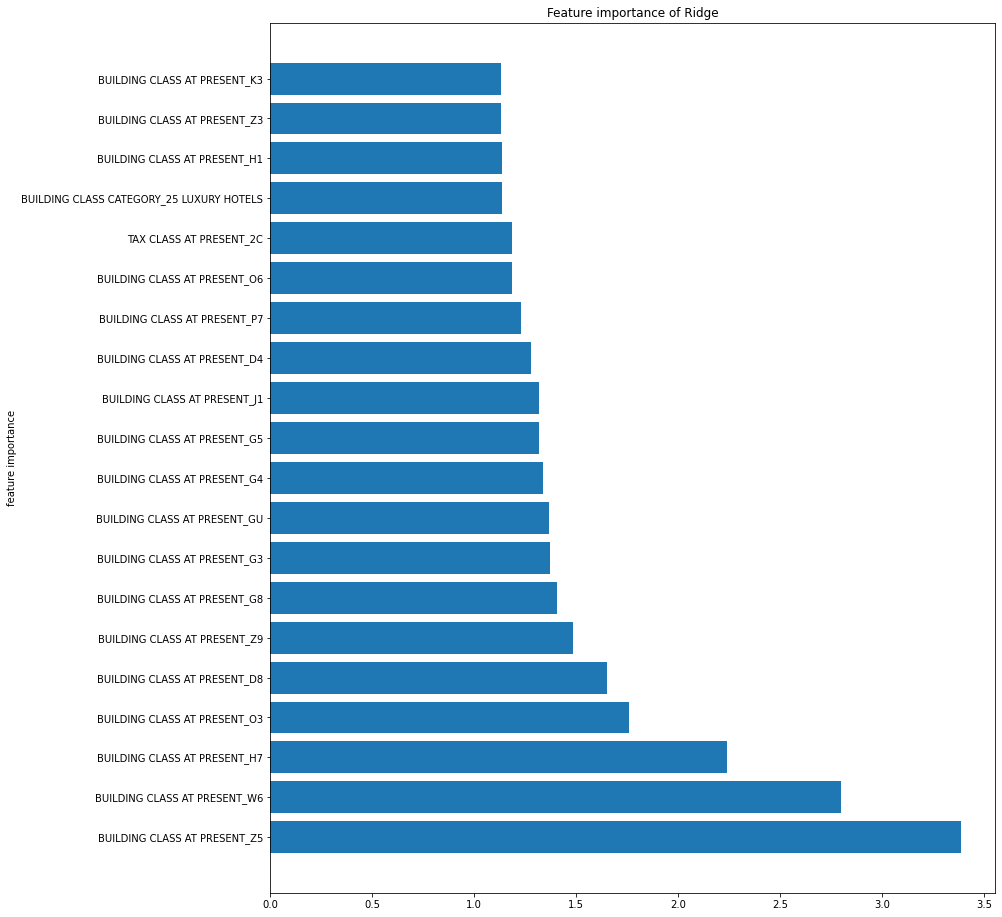

In [82]:
ridge_result = pd.DataFrame({'feature': X_train.columns, 'importance': abs(ridge_reg.coef_)})
ridge_result_sorted = ridge_result.sort_values(by = 'importance', ascending = False)[:20]

fig, ax1 = plt.subplots(figsize = (13,16))
ax1.barh(ridge_result_sorted['feature'], ridge_result_sorted['importance'])
ax1.set_ylabel('feature importance')
ax1.set_title( 'Top 20 Important Feature of Ridge')
plt.show()

# Deep Neural Multilayer Perceptron - MLP Regression

The R2 score of MLP model is  -2.9199186004119406
MSE: 1.925933596541163
RMSE: 1.3877800966079472


Text(0.5, 1.0, 'Residual plot of MLP')

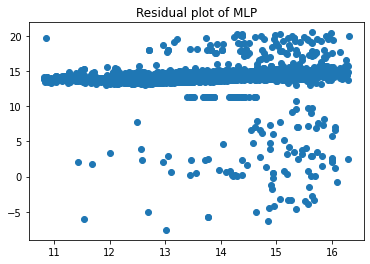

In [68]:
mlp = MLPRegressor(random_state = 42)
start = time.process_time()
model = mlp.fit(X_train,y_train)
mlp_predict =  model.predict(X_test)

print("The R2 score of MLP model is ", r2_score(y_test, mlp_predict))
print('MSE:', metrics.mean_squared_error(y_test, mlp_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, mlp_predict)))

plt.scatter(y_test, mlp_predict)
plt.title('Residual plot of MLP')

# K Neighbors Regression

The R2 score of KNN model is  0.5172444971453058
MSE: 0.2371873338811861
RMSE: 0.4870188229228785


Text(0.5, 1.0, 'Residual plot of KNN')

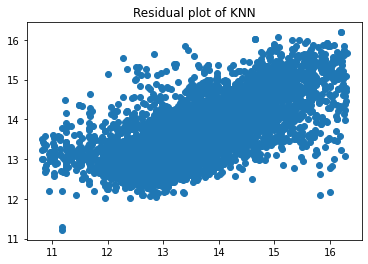

In [69]:
knn = KNeighborsRegressor()
start = time.process_time()
model = knn.fit(X_train,y_train)
knn_predict =  model.predict(X_test)

print("The R2 score of KNN model is ", r2_score(y_test, knn_predict))
print('MSE:', metrics.mean_squared_error(y_test, knn_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, knn_predict)))

plt.scatter(y_test, knn_predict)
plt.title('Residual plot of KNN')


# Decision Tree Regression

The R2 score of Decision Tree Regression model is  0.3138329534205059
MSE: 0.3371274515006501
RMSE: 0.5806267747018303


Text(0.5, 1.0, 'Residual plot of Decision Tree')

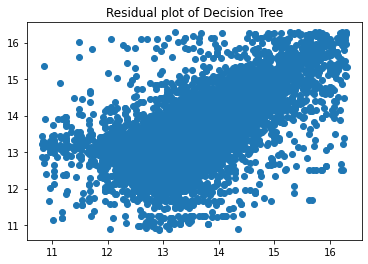

In [70]:
dtree = DecisionTreeRegressor(random_state = 42)
start = time.process_time()
model = dtree.fit(X_train,y_train)
dtree_predict =  model.predict(X_test)

print("The R2 score of Decision Tree Regression model is ", r2_score(y_test, dtree_predict))
print('MSE:', metrics.mean_squared_error(y_test, dtree_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtree_predict)))

plt.scatter(y_test, dtree_predict)
plt.title('Residual plot of Decision Tree')

# Variable Importances

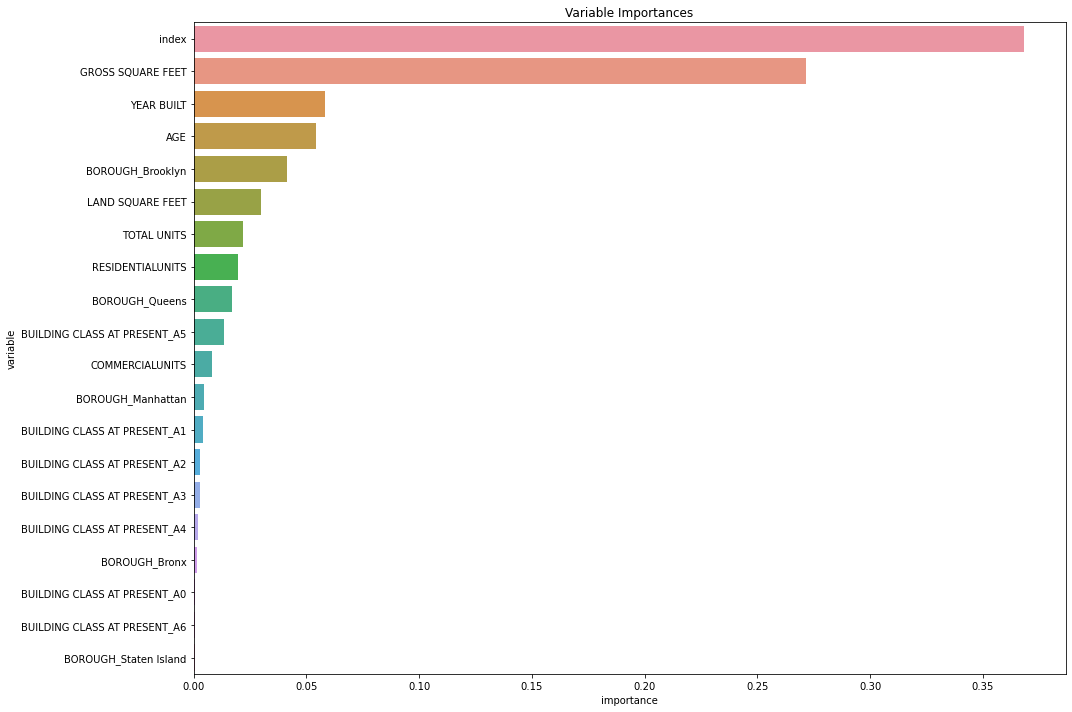

In [85]:
rankings = model.feature_importances_.tolist()[:20]
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)
plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="variable",
            data=importance)
plt.title('Variable Importances')
plt.tight_layout()


# Random Forest Regression

### Performed Hyper-Parameter Tuning in order to find best parameters.

In [92]:
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf = RandomForestRegressor(random_state = 42)

rf_tuned = GridSearchCV(estimator = rf,
                            param_grid = param_grid,
                            cv = 2,
                            n_jobs=-1,
                        verbose=0)

rf_tuned.fit(X_train, y_train)
rf_tuned.best_estimator_

RandomForestRegressor(max_depth=50, max_features=16, n_estimators=300,
                      random_state=42)

In [93]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=50, max_features=16, n_estimators=300,
                      random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print("The accuracy of random forest model is ", r2_score(y_test,y_pred_rf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

The accuracy of random forest model is  0.6298389427357718
MSE: 0.18186745414597535
RMSE: 0.4264592057230977


# Ada Boost

In [89]:
from sklearn.ensemble import AdaBoostRegressor
adar = AdaBoostRegressor()
adar.fit(X_train, y_train)
y_pred = adar.predict(X_test)
print("The accuracy of AdaBoost regression model is ", r2_score(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The accuracy of AdaBoost regression model is  0.34964346205721175
MSE: 0.31953303979898584
RMSE: 0.5652725358612303


# Cat boost

Learning rate set to 0.073676
0:	learn: 0.6695773	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6501466	total: 23ms	remaining: 11.5s
2:	learn: 0.6318555	total: 30.8ms	remaining: 10.2s
3:	learn: 0.6151771	total: 39.2ms	remaining: 9.75s
4:	learn: 0.6011680	total: 42.9ms	remaining: 8.54s
5:	learn: 0.5878837	total: 46.4ms	remaining: 7.68s
6:	learn: 0.5763437	total: 50.5ms	remaining: 7.17s
7:	learn: 0.5651885	total: 54.3ms	remaining: 6.73s
8:	learn: 0.5551774	total: 58.7ms	remaining: 6.47s
9:	learn: 0.5463817	total: 63.1ms	remaining: 6.25s
10:	learn: 0.5386954	total: 67.2ms	remaining: 6.04s
11:	learn: 0.5320354	total: 71.8ms	remaining: 5.91s
12:	learn: 0.5257878	total: 76.8ms	remaining: 5.83s
13:	learn: 0.5199632	total: 80.9ms	remaining: 5.7s
14:	learn: 0.5149783	total: 85.7ms	remaining: 5.63s
15:	learn: 0.5104471	total: 89.9ms	remaining: 5.53s
16:	learn: 0.5058938	total: 94.3ms	remaining: 5.46s
17:	learn: 0.5019863	total: 99.4ms	remaining: 5.42s
18:	learn: 0.4986201	total: 104ms	remaining: 5.

184:	learn: 0.4243620	total: 762ms	remaining: 3.36s
185:	learn: 0.4243461	total: 766ms	remaining: 3.35s
186:	learn: 0.4241621	total: 771ms	remaining: 3.35s
187:	learn: 0.4239188	total: 776ms	remaining: 3.35s
188:	learn: 0.4239039	total: 781ms	remaining: 3.35s
189:	learn: 0.4236764	total: 786ms	remaining: 3.35s
190:	learn: 0.4235058	total: 792ms	remaining: 3.35s
191:	learn: 0.4233275	total: 795ms	remaining: 3.35s
192:	learn: 0.4231583	total: 799ms	remaining: 3.34s
193:	learn: 0.4229259	total: 803ms	remaining: 3.33s
194:	learn: 0.4228853	total: 806ms	remaining: 3.33s
195:	learn: 0.4228772	total: 811ms	remaining: 3.32s
196:	learn: 0.4227876	total: 815ms	remaining: 3.32s
197:	learn: 0.4226502	total: 819ms	remaining: 3.32s
198:	learn: 0.4225768	total: 823ms	remaining: 3.31s
199:	learn: 0.4225677	total: 827ms	remaining: 3.31s
200:	learn: 0.4223857	total: 831ms	remaining: 3.3s
201:	learn: 0.4222196	total: 835ms	remaining: 3.3s
202:	learn: 0.4220754	total: 839ms	remaining: 3.29s
203:	learn: 0.

363:	learn: 0.4071338	total: 1.55s	remaining: 2.7s
364:	learn: 0.4070544	total: 1.55s	remaining: 2.7s
365:	learn: 0.4069428	total: 1.55s	remaining: 2.69s
366:	learn: 0.4069389	total: 1.56s	remaining: 2.69s
367:	learn: 0.4068322	total: 1.56s	remaining: 2.69s
368:	learn: 0.4067592	total: 1.57s	remaining: 2.68s
369:	learn: 0.4066895	total: 1.57s	remaining: 2.67s
370:	learn: 0.4066406	total: 1.57s	remaining: 2.67s
371:	learn: 0.4065024	total: 1.58s	remaining: 2.66s
372:	learn: 0.4064965	total: 1.58s	remaining: 2.66s
373:	learn: 0.4064101	total: 1.58s	remaining: 2.65s
374:	learn: 0.4063693	total: 1.59s	remaining: 2.65s
375:	learn: 0.4062210	total: 1.59s	remaining: 2.65s
376:	learn: 0.4061042	total: 1.6s	remaining: 2.64s
377:	learn: 0.4059915	total: 1.6s	remaining: 2.64s
378:	learn: 0.4058973	total: 1.61s	remaining: 2.63s
379:	learn: 0.4057186	total: 1.61s	remaining: 2.63s
380:	learn: 0.4056212	total: 1.61s	remaining: 2.62s
381:	learn: 0.4056030	total: 1.62s	remaining: 2.62s
382:	learn: 0.40

563:	learn: 0.3946574	total: 2.32s	remaining: 1.8s
564:	learn: 0.3946070	total: 2.33s	remaining: 1.79s
565:	learn: 0.3945311	total: 2.33s	remaining: 1.79s
566:	learn: 0.3943887	total: 2.34s	remaining: 1.78s
567:	learn: 0.3943423	total: 2.34s	remaining: 1.78s
568:	learn: 0.3942148	total: 2.35s	remaining: 1.78s
569:	learn: 0.3941297	total: 2.35s	remaining: 1.77s
570:	learn: 0.3941167	total: 2.35s	remaining: 1.77s
571:	learn: 0.3940824	total: 2.36s	remaining: 1.76s
572:	learn: 0.3940723	total: 2.36s	remaining: 1.76s
573:	learn: 0.3940113	total: 2.36s	remaining: 1.75s
574:	learn: 0.3939560	total: 2.37s	remaining: 1.75s
575:	learn: 0.3939346	total: 2.37s	remaining: 1.75s
576:	learn: 0.3938374	total: 2.38s	remaining: 1.74s
577:	learn: 0.3938345	total: 2.38s	remaining: 1.74s
578:	learn: 0.3938195	total: 2.38s	remaining: 1.73s
579:	learn: 0.3937785	total: 2.39s	remaining: 1.73s
580:	learn: 0.3937332	total: 2.39s	remaining: 1.72s
581:	learn: 0.3936638	total: 2.39s	remaining: 1.72s
582:	learn: 0

774:	learn: 0.3841594	total: 3.11s	remaining: 904ms
775:	learn: 0.3841514	total: 3.12s	remaining: 900ms
776:	learn: 0.3840748	total: 3.12s	remaining: 896ms
777:	learn: 0.3840375	total: 3.13s	remaining: 892ms
778:	learn: 0.3839848	total: 3.13s	remaining: 888ms
779:	learn: 0.3839834	total: 3.13s	remaining: 884ms
780:	learn: 0.3838486	total: 3.14s	remaining: 880ms
781:	learn: 0.3838177	total: 3.14s	remaining: 875ms
782:	learn: 0.3837951	total: 3.14s	remaining: 871ms
783:	learn: 0.3837900	total: 3.15s	remaining: 867ms
784:	learn: 0.3837528	total: 3.15s	remaining: 863ms
785:	learn: 0.3837235	total: 3.15s	remaining: 859ms
786:	learn: 0.3836571	total: 3.16s	remaining: 855ms
787:	learn: 0.3836061	total: 3.16s	remaining: 851ms
788:	learn: 0.3835645	total: 3.17s	remaining: 847ms
789:	learn: 0.3835287	total: 3.17s	remaining: 843ms
790:	learn: 0.3835137	total: 3.17s	remaining: 838ms
791:	learn: 0.3834691	total: 3.18s	remaining: 834ms
792:	learn: 0.3834581	total: 3.18s	remaining: 830ms
793:	learn: 

934:	learn: 0.3771905	total: 3.7s	remaining: 257ms
935:	learn: 0.3771358	total: 3.7s	remaining: 253ms
936:	learn: 0.3770982	total: 3.71s	remaining: 249ms
937:	learn: 0.3770844	total: 3.71s	remaining: 245ms
938:	learn: 0.3770483	total: 3.71s	remaining: 241ms
939:	learn: 0.3769984	total: 3.72s	remaining: 237ms
940:	learn: 0.3769482	total: 3.72s	remaining: 233ms
941:	learn: 0.3769470	total: 3.73s	remaining: 229ms
942:	learn: 0.3768810	total: 3.73s	remaining: 225ms
943:	learn: 0.3768660	total: 3.73s	remaining: 221ms
944:	learn: 0.3768292	total: 3.74s	remaining: 218ms
945:	learn: 0.3767996	total: 3.74s	remaining: 214ms
946:	learn: 0.3767470	total: 3.75s	remaining: 210ms
947:	learn: 0.3767398	total: 3.75s	remaining: 206ms
948:	learn: 0.3767387	total: 3.75s	remaining: 202ms
949:	learn: 0.3767210	total: 3.76s	remaining: 198ms
950:	learn: 0.3766679	total: 3.76s	remaining: 194ms
951:	learn: 0.3766168	total: 3.76s	remaining: 190ms
952:	learn: 0.3766034	total: 3.77s	remaining: 186ms
953:	learn: 0.

Text(0.5, 1.0, 'Residual plot of Cat Boost')

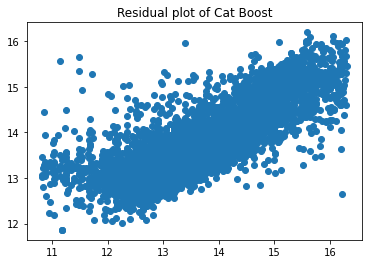

In [88]:
modelcat = cb.CatBoostRegressor(loss_function='RMSE')
modelcat.fit(X_train,y_train)
cat_predict = modelcat.predict(X_test)

print("The R2 score of Cat Boost model is ", r2_score(y_test, cat_predict))
print('MSE:', metrics.mean_squared_error(y_test, cat_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, cat_predict)))

plt.scatter(y_test, cat_predict)
plt.title('Residual plot of Cat Boost')

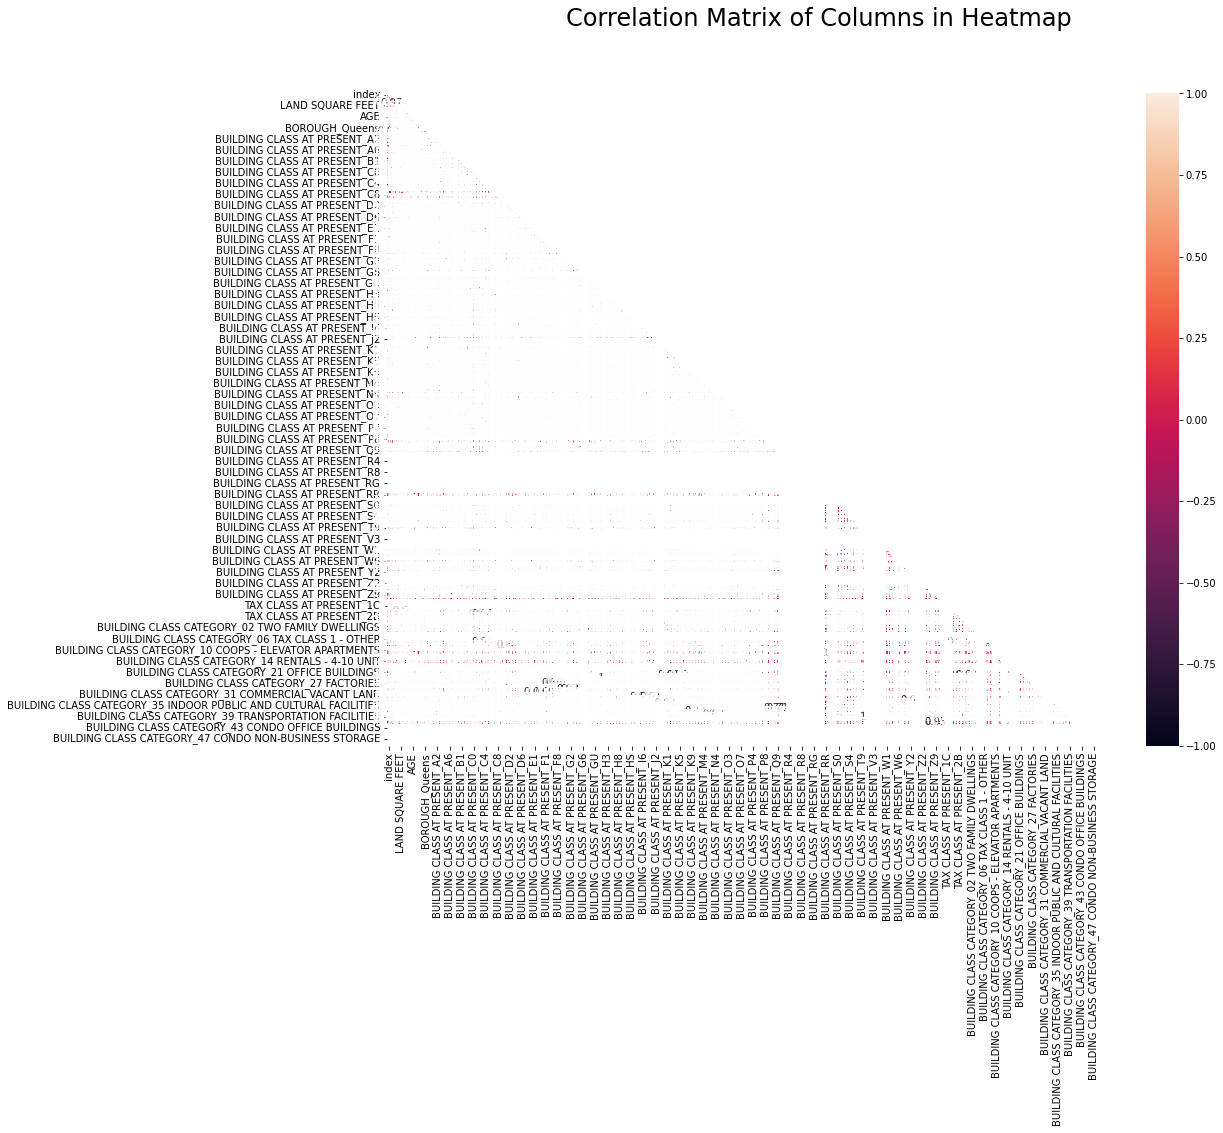

In [74]:
mtr = df_new.corr()
# Generating a mask for the upper triangle
mask = np.zeros_like(mtr)
mask[np.triu_indices_from(mask)] = True
# Setting up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,12))
plt.suptitle("Correlation Matrix of Columns in Heatmap", size=24)
# Draw the heatmap with the mask and annotations
sns.heatmap(mtr, mask= mask, annot=True, annot_kws={"size": 10});

# Feature Importance of the Best Model: Cat boost

Text(0.5, 1.0, 'Feature Importance')

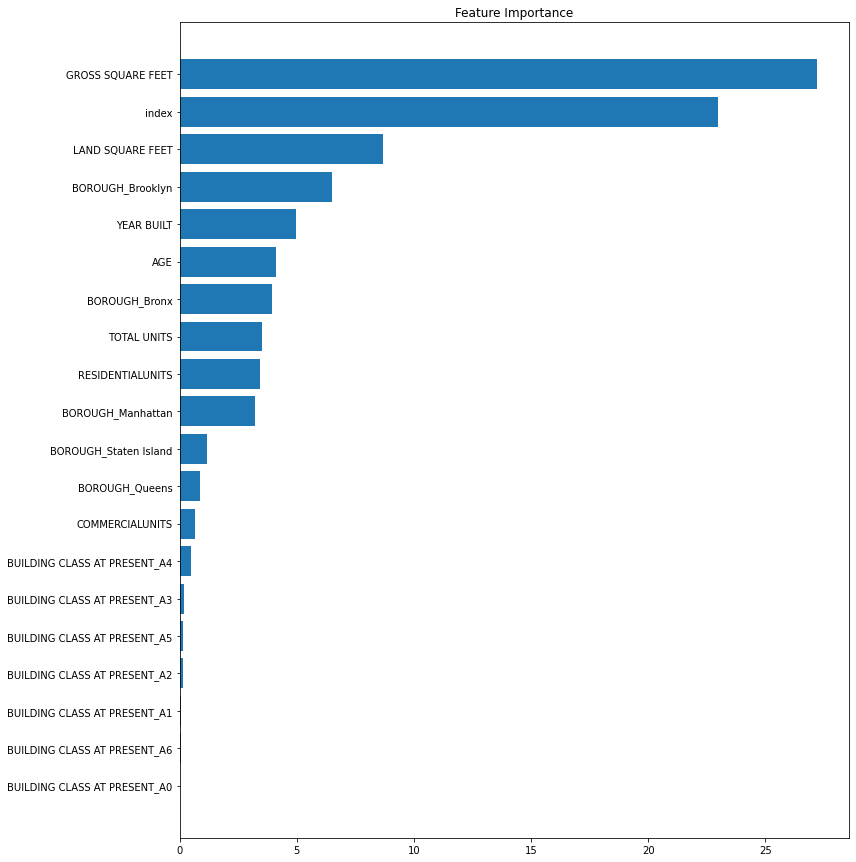

In [84]:
feature_importance = modelcat.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')